# Simple dose computation

In this example we are going to create a generic CT and use the MCsquare dose calculator to compute the dose image

In [1]:
#imports

import numpy as np

from matplotlib import pyplot as plt
import math
from opentps.core.data.images import CTImage
from opentps.core.data.images import ROIMask
from opentps.core.data.plan import PlanDesign
from opentps.core.data import DVH
from opentps.core.data import Patient
from opentps.core.io import mcsquareIO
from opentps.core.io.scannerReader import readScanner
from opentps.core.processing.doseCalculation.doseCalculationConfig import DoseCalculationConfig
from opentps.core.processing.doseCalculation.mcsquareDoseCalculator import MCsquareDoseCalculator
from opentps.core.processing.imageProcessing.resampler3D import resampleImage3DOnImage3D,resampleImage3D

27/07/2023 02:00:32 PM - root - INFO - Loading logging configuration: c:\Users\romai\anaconda3\envs\OpenTPS\lib\site-packages\opentps\core\config\logger\logging_config.json
27/07/2023 02:00:32 PM - opentps.core._loggingConfig - INFO - Log level set: INFO
27/07/2023 02:00:32 PM - opentps.core.processing.imageProcessing.cupyImageProcessing - WARNING - Cannot import Cupy module
27/07/2023 02:00:33 PM - opentps.core.processing.registration.registrationMorphons - WARNING - cupy not found.
27/07/2023 02:00:33 PM - opentps.core.processing.C_libraries.libInterp3_wrapper - WARNING - cupy not found.


## Generic CT creation

We will first create a generic CT of a box filled with water and air

In [2]:
ctCalibration = readScanner(DoseCalculationConfig().scannerFolder)
bdl = mcsquareIO.readBDL(DoseCalculationConfig().bdlFile)

patient = Patient()
patient.name = 'Patient'

ctSize = 150

ct = CTImage()
ct.name = 'CT'
ct.patient = patient

huAir = -1024.
huWater = ctCalibration.convertRSP2HU(1.)
data = huAir * np.ones((ctSize, ctSize, ctSize))
data[:, 50:, :] = huWater
ct.imageArray = data

## Region of interest

We will now create a region of interest wich is a small 3D box of size 20\*20\*20

In [3]:
roi = ROIMask()
roi.patient = patient
roi.name = 'TV'
roi.color = (255, 0, 0) # red
data = np.zeros((ctSize, ctSize, ctSize)).astype(bool)
data[65:85, 65:85, 65:85] = True
roi.imageArray = data

## Configuration of MCsquare

To configure the MCsquare calculator we need to calibrate it with the CT calibration obtained above

In [4]:
# Configure MCsquare
mc2 = MCsquareDoseCalculator()
mc2.beamModel = bdl
mc2.ctCalibration = ctCalibration
mc2.nbPrimaries = 1e7

## Plan creation

We will now create a plan and create one beam

In [5]:
# Design plan
beamNames = ["Beam1","Beam2","Beam3"]
gantryAngles = [0.,90.,270.]
couchAngles = [0.,0.,0.]

# Generate new plan
planDesign = PlanDesign()
planDesign.ct = ct
planDesign.targetMask = roi
planDesign.gantryAngles = gantryAngles
planDesign.beamNames = beamNames
planDesign.couchAngles = couchAngles
planDesign.calibration = ctCalibration
planDesign.spotSpacing = 5.0
planDesign.layerSpacing = 5.0
planDesign.targetMargin = 5.0

plan = planDesign.buildPlan()  # Spot placement
plan.PlanName = "NewPlan"

27/07/2023 02:00:48 PM - opentps.core.data.plan._planDesign - INFO - Building plan ...
27/07/2023 02:00:49 PM - opentps.core.processing.planOptimization.planInitializer - INFO - Target is dilated using a margin of 5.0 mm. This process might take some time.
27/07/2023 02:00:49 PM - opentps.core.processing.imageProcessing.roiMasksProcessing - INFO - Using SITK to dilate mask.
27/07/2023 02:00:56 PM - opentps.core.data.plan._planDesign - INFO - New plan created in 7.364245414733887 sec
27/07/2023 02:00:56 PM - opentps.core.data.plan._planDesign - INFO - Number of spots: 913


## Center of mass

Here we look at the part of the 3D CT image where "stuff is happening" by getting the CoM. We use the function resampleImage3DOnImage3D to the same array size for both images.

27/07/2023 02:00:56 PM - opentps.core.processing.imageProcessing.roiMasksProcessing - INFO - Using SITK to dilate mask.


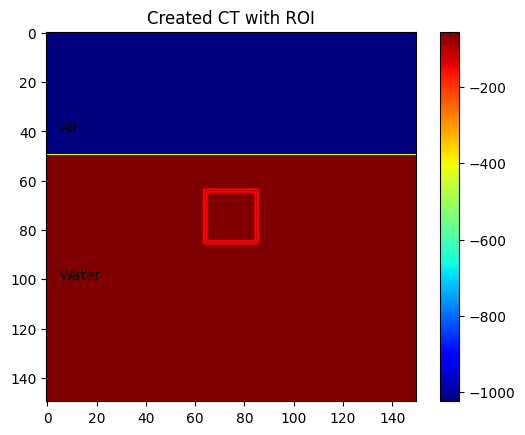

In [6]:
roi = resampleImage3DOnImage3D(roi, ct)
COM_coord = roi.centerOfMass
COM_index = roi.getVoxelIndexFromPosition(COM_coord)
Z_coord = COM_index[2]

img_ct = ct.imageArray[:, :, Z_coord].transpose(1, 0)
contourTargetMask = roi.getBinaryContourMask()
img_mask = contourTargetMask.imageArray[:, :, Z_coord].transpose(1, 0)

image = plt.imshow(img_ct,cmap='jet')
plt.colorbar(image)
plt.contour(img_mask,colors="red")
plt.title("Created CT with ROI")
plt.text(5,40,"Air")
plt.text(5,100,"Water")
plt.show()

## Dose computation

We now use the MCsquared dose calculator to compute the dose of the created plan

In [7]:
doseImage = mc2.computeDose(ct, plan)

27/07/2023 02:00:56 PM - opentps.core.processing.doseCalculation.mcsquareDoseCalculator - INFO - Prepare MCsquare Dose calculation
27/07/2023 02:00:56 PM - opentps.core.io.mhdIO - INFO - Write MHD file: C:\Users\romai\openTPS_workspace\Simulations\MCsquare_simulation\CT.mhd
27/07/2023 02:00:57 PM - opentps.core.io.mcsquareIO - INFO - Write plan: C:\Users\romai\openTPS_workspace\Simulations\MCsquare_simulation\PlanPencil.txt
27/07/2023 02:00:57 PM - opentps.core.processing.doseCalculation.mcsquareDoseCalculator - INFO - Start MCsquare simulation


In [10]:
img_dose = resampleImage3DOnImage3D(doseImage, ct)
img_dose = img_dose.imageArray[:, :, Z_coord].transpose(1, 0)
scoringSpacing = [2, 2, 2]
scoringGridSize = [int(math.floor(i / j * k)) for i, j, k in zip([150,150,150], scoringSpacing, [1,1,1])]
roiResampled = resampleImage3D(roi, origin=ct.origin, gridSize=scoringGridSize, spacing=scoringSpacing)
target_DVH = DVH(roiResampled, doseImage)

NameError: name 'math' is not defined

NameError: name 'target_DVH' is not defined

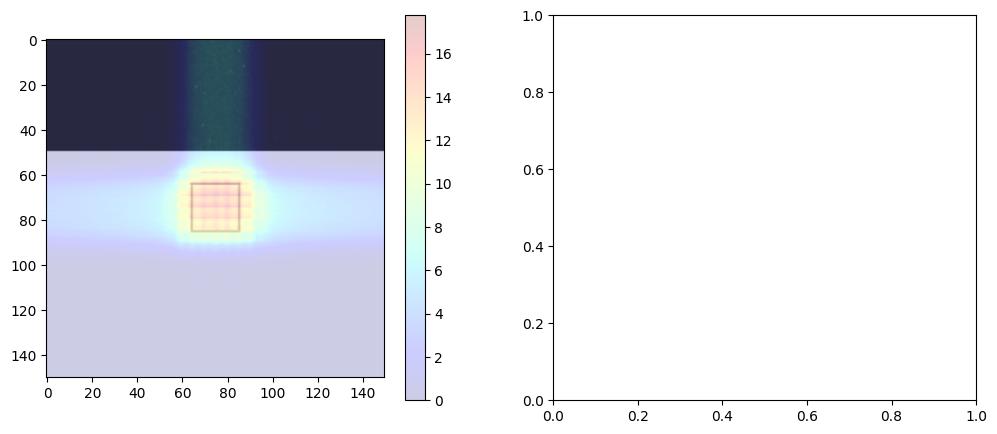

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
#ax[0].axes.get_xaxis().set_visible(False)
#ax[0].axes.get_yaxis().set_visible(False)
ax[0].imshow(img_ct, cmap='gray')
ax[0].imshow(img_mask, alpha=.2, cmap='binary')  # PTV
dose = ax[0].imshow(img_dose, cmap='jet', alpha=.2)
plt.colorbar(dose, ax=ax[0])
ax[1].plot(target_DVH.histogram[0], target_DVH.histogram[1], label=target_DVH.name)
ax[1].set_xlabel("Dose (Gy)")
ax[1].set_ylabel("Volume (%)")
plt.grid(True)
plt.legend()

plt.show()